# How to use the `smooth_cal` module in `hera_cal`

`hera_cal`'s `smooth_cal` module enables smoothing or "conditioning" of calibration solutions. This includes:

* 2D time and frequency smoothing by restricting calibrations to some minimum frequency and time scale, using `aipy.deconv.clean`
* Frequency smoothing by restricting the calibrations to some minimum frequency scale (or alternatively, some maximum delay).
* Time smoothing via a rolling Gaussian average of some given width.

The module is designed to load in several calibration files in the `.calfits` format, along with associated files that contain flags applied to visibilities in the `.npz` format from `hera_qm.xrfi`. It can also output smoothed calibration solutions, along with updated flags, to `calfits` files. Whenever possible, flagged gains will be updated based on the smoothing, however they will remain flagged.

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from copy import deepcopy
from hera_cal.smooth_cal import CalibrationSmoother
from hera_cal.data import DATA_PATH
import glob

## Loading data

In this demo, we'll be smoothing the calibration for antenna 54, x-polarization, for three consecutive observations on 2458101. They are loaded into a `CalibrationSmoother` object as follows:

In [4]:
ant = (54,'jxx')
calfits_list = glob.glob(os.path.join(DATA_PATH, 'test_input/*.abs.calfits_54x_only'))
flags_npz_list = glob.glob(os.path.join(DATA_PATH, 'test_input/*.uvOCR_53x_54x_only.flags.applied.npz'))
cs = CalibrationSmoother(calfits_list, flags_npz_list=flags_npz_list)

## 2D Smoothing in Time and Frequency

2D smoothing is performed using `aipy.deconv.cleanTime smoothing is performed using a weighted rolling Gaussian average. To avoid edge effets, the calibration solutions are mirrored in time before smoothing (instead of assuming periodic boundary conditions). For wide smoothing kernels, this mirroring can happen several times. This process is controlled by two paramters:
a
* `filter_scale`: the FHMW of the Gaussian temporal smoothing kernel (given in seconds)
* `mirror_kernel_min_sigmas`: The number of stdev into the Gaussian kernel one must go before edge effects can be ignored. This sets the number of times we mirror the gains to produce smoothed solution.

The smoothed calibration solutions are always stored in the dictionary `cs.filtered_gain_grids`. For interactive work, this can be reset with `cs.reset_filtering()` without having to reload the data and calibration solutions. To pick out the filtered gains associated with a particular file, one can call `cs.filtered_gain_grids[ant][cs.time_indices[calfits_file],:]`

## Smoothing in time

Time smoothing is performed using a weighted rolling Gaussian average. To avoid edge effets, the calibration solutions are mirrored in time before smoothing (instead of assuming periodic boundary conditions). For wide smoothing kernels, this mirroring can happen several times. This process is controlled by two paramters:

* `filter_scale`: the FHMW of the Gaussian temporal smoothing kernel (given in seconds)
* `mirror_kernel_min_sigmas`: The number of stdev into the Gaussian kernel one must go before edge effects can be ignored. This sets the number of times we mirror the gains to produce smoothed solution.

The smoothed calibration solutions are always stored in the dictionary `cs.filtered_gain_grids`. For interactive work, this can be reset with `cs.reset_filtering()` without having to reload the data and calibration solutions. To pick out the filtered gains associated with a particular file, one can call `cs.filtered_gain_grids[ant][cs.time_indices[calfits_file],:]`

In [5]:
cs.time_filter(filter_scale=1800.0, mirror_kernel_min_sigmas=5)
time_filtered = deepcopy(cs.filtered_gain_grids[ant])

## Smoothing in frequency

Frequency smoothing is performed using a delay filter using `uvtools.dspec.high_pass_fourier_filter()` and inheriting its keyword parameters. The default window is `'tukey'` with `alpha=0.5` (rather than `'blackman-harris'` or `'none'` i.e. tophat). Modes in frequency shorter than `filter_scale` are removed. In this case, the filter is at 10 MHz, which means that delay modes above 100 ns are removed from the calibration solutions. 

In [6]:
cs.freq_filter(filter_scale=10.0)

## Writing to disk

Updated calfits files can be written to disk with `cs.write_smoothed_cal`  by replacing substrings of the paths to the input calfits files using the `output_replace=(substring_to_replace, substring_to_replace_it_with)` format. This function provides an interface to `hera_cal.io.update_cal` with the associated keyword options.

In [7]:
cs.write_smoothed_cal(output_replace=('test_input/','test_output/smoothed_'),
                      add_to_history='Written by running_smooth_cal.ipynb', clobber=True)

## Example results:

divide by zero encountered in divide
invalid value encountered in divide


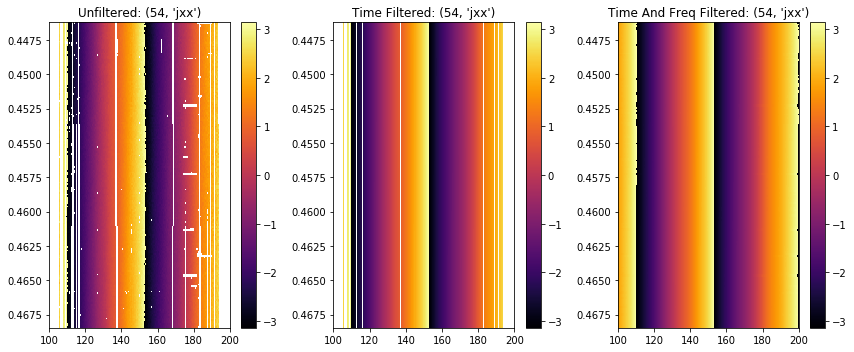

In [8]:
extent = [cs.freqs[0]/1e6, cs.freqs[-1]/1e6, cs.time_grid[-1]-np.floor(cs.time_grid[-1]), cs.time_grid[0]-np.floor(cs.time_grid[0])]
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(np.angle(cs.gain_grids[ant]) / (~cs.flag_grids[ant]), cmap='inferno', aspect='auto', extent=extent)
# plt.clim([.0,.05])
plt.colorbar()
plt.title('Unfiltered: ' + str(ant));

plt.subplot(132)

plt.imshow(np.angle(time_filtered) / np.sum((~cs.flag_grids[ant]),axis=0).astype(bool), cmap='inferno', aspect='auto', extent=extent)
# plt.clim([.0,.05])
plt.colorbar()
plt.title('Time Filtered: ' + str(ant))

plt.subplot(133)
plt.imshow(np.angle(cs.filtered_gain_grids[ant]), cmap='inferno', aspect='auto', extent=extent)
# plt.clim([.0,.05])
plt.colorbar()
plt.title('Time And Freq Filtered: ' + str(ant))
plt.tight_layout()

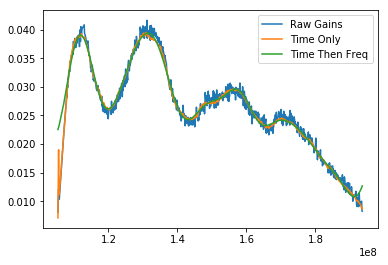

In [9]:
plt.figure()
integration = 90
unflagged = ~cs.flag_grids[ant][integration,:]
plt.plot(cs.freqs[unflagged], np.abs(cs.gain_grids[ant][integration,unflagged]), label='Raw Gains')
plt.plot(cs.freqs[unflagged], np.abs(time_filtered[integration,unflagged]), label='Time Only')
plt.plot(cs.freqs[unflagged], np.abs(cs.filtered_gain_grids[ant][integration,unflagged]), label='Time Then Freq')
plt.legend();

In [10]:
for cal in cs.cals:    
    try:
        os.remove(cal.replace('test_input/','test_output/smoothed_'))
    except (OSError):
        pass